# Visualizing the manually-curated data
In this notebook, we load some manually-curated data on papers using Diversity Statements, and visualize various aspects of this data.

In [1]:
#!usr/bin/bash/python3

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn3_circles, venn3_unweighted
from matplotlib_venn import _common, _venn3
import matplotlib
import re

%matplotlib inline

## Load the data
This data was gathered manually from a Google Scholar search for the papers that cite the preprint on this topic: 

Dworkin, J. D., Linn, K. A., Teich, E. G., Zurn, P., Shinohara, R. T., & Bassett, D. S. (2020). The extent and drivers of gender imbalance in neuroscience reference lists. arXiv preprint arXiv:2001.01002.

In [2]:
datafile = '../../data/citing_papers__manually_gathered.csv'
df = pd.read_csv(datafile)
print('Data columns: ', list(df.columns))
df.head(2)

Data columns:  ['paper_opencitations', 'code_opencitations', 'paper_googlescholar', 'code_googlescholar', 'title', 'bassett_author', 'arxiv', 'doi', 'preprint', 'paper_citation', 'code_citation', 'diversity_statement', 'ds_text']


,paper_opencitations,code_opencitations,paper_googlescholar,code_googlescholar,title,bassett_author,arxiv,doi,preprint,paper_citation,code_citation,diversity_statement,ds_text
0,1,0,1,1,Temporal sequences of brain activity at rest a...,1,0,10.1038/s42003-020-0961-x,0,1,1,1,Recent work in neuroscience85and otherfields86...
1,0,0,1,0,Models of communication and control for brain ...,1,arXiv:2002.07029,0,1,1,1,1,Recent work in neuroscience and other fields h...


## Looking at features of papers that might help us find them automatically
Here, we look at whether papers contain a diversity statement, and whether they cite the code and/or the original paper. This way, we can get an idea of how to make an automatic search that would find all relevant papers. 

In [3]:
def venn_of_df(df, labels):
    subsets = []
    for col in df.columns:
        s = set(df.index[df[col] > 0].tolist())
        subsets.append(s)

    #labels = [label.replace('_', ' ').capitalize() for label in df.columns]

    v = venn3_unweighted(subsets, set_labels=labels)
    areas = (1, 1, 1, 1, 1, 1, 1)
    centers, radii = _venn3.solve_venn3_circles(areas)
    ax = plt.gca()
    _common.prepare_venn_axes(ax, centers, radii)

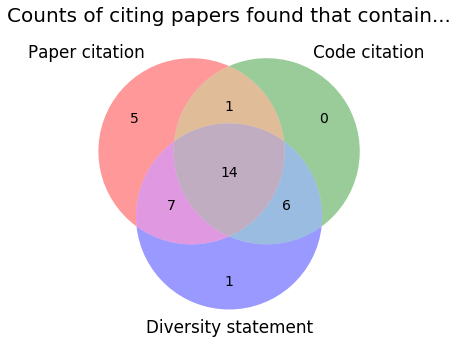

In [4]:
plt.figure(figsize=(9,5))
matplotlib.rc('font', **{'size': 14})

cols = ['paper_citation', 'code_citation', 'diversity_statement']
labels = [label.replace('_', ' ').capitalize() for label in cols]
venn_of_df(df[cols], labels=labels)
plt.title('Counts of citing papers found that contain...', fontsize=20)
plt.tight_layout()
plt.savefig('../../reports/figures/venn_diagram_content.png')

## Looking at where papers can be found
I did manual searches on Google Scholar for papers that cite the [code](https://scholar.google.com/scholar?cites=9664289398725956584&as_sdt=2005&sciodt=0,5&hl=en) and those that cite the [paper](https://scholar.google.com/scholar?cites=5476688246125765713&as_sdt=2005&sciodt=0,5&hl=en). 

I also did a search with opencitations.net to find DOIs of papers that cite the DOI of the [code](https://opencitations.net/index/coci/api/v1/citations/10.5281/zenodo.3672109) and the [paper](https://opencitations.net/index/coci/api/v1/citations/10.1101/2020.01.03.894378). 
The search for the code revealed 0 DOIs, so "Code opencitations" is not included in this diagram.

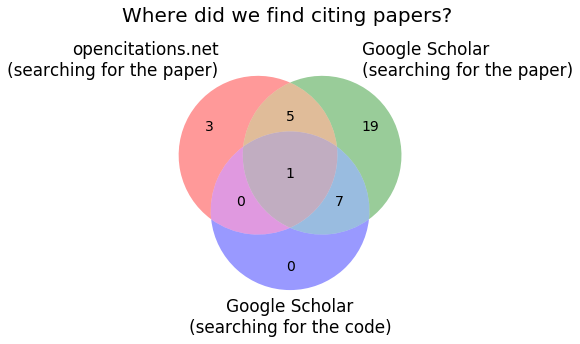

In [5]:
plt.figure(figsize=(9,5))
matplotlib.rc('font', **{'size': 14})

cols = ['paper_opencitations',
 'paper_googlescholar',
 'code_googlescholar']
labels = ['opencitations.net\n(searching for the paper)',
          'Google Scholar\n(searching for the paper)',
          'Google Scholar\n(searching for the code)']
venn_of_df(df[cols], labels=labels)
plt.title('Where did we find citing papers? \n', fontsize=20)
plt.tight_layout()
plt.savefig('../../reports/figures/venn_diagram_sources.png')

## Other interesting notes about the citing papers


In [6]:
print(f'{len(df)} papers were found')

print('%d papers contain a diversity statement' %df['diversity_statement'].sum())

n_preprints = df['preprint'].sum()
n_articles = len(df) - df['preprint'].sum()
print(f'{n_preprints} are preprints, {n_articles} journal articles')

n_by_bassett = df['bassett_author'].sum()
n_not_by_bassett = len(df) - n_by_bassett
print(f'{n_by_bassett} include Danielle Bassett as an author, {n_not_by_bassett} do not')

35 papers were found
28 papers contain a diversity statement
17 are preprints, 18 journal articles
23 include Danielle Bassett as an author, 12 do not


# Compare reported percentages to the benchmarks
Here, we extract the percentages reported in the citing papers' diversity statements, in order to visualize how they differ from the benchmarks reported in the original preprint. 

These are the possible labels for percentages listed in diversity statements. Which labels apply depends on how many percentages are given. Note that this may be inaccurate for some papers, but it's accurate for the papers in the current data (based on a manual check).

In [7]:
possible_labels = {
    4: ['mm', 'mw', 'wm', 'ww'],
    5: ['mm', 'mw', 'wm', 'ww', 'unknown'],
    6: ['mm', 'mw', 'wm', 'ww', 'nonbinary','unknown'],
    8: ['mm', 'mw', 'wm', 'ww',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww'],
    9: ['mm', 'mw', 'wm', 'ww',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww'],
    10: ['mm', 'mw', 'wm', 'ww', 'unknown',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww', 'rel_unknown'],
    11: ['mm', 'mw', 'wm', 'ww', 'nonbinary', 'unknown',
        'rel_mm', 'rel_mw', 'rel_wm', 'rel_ww', 'rel_unknown'],
}

Next, we the percentages in the diversity statement texts that were manually copied & pasted into the data table. 

We put the percentages in a dictionary with the labels corresponding to the number of percentages, and store this in the dataframe. 

In [8]:
pattern = '\−*\s*\d*.\d*\s*\%'
for n, text in enumerate(df['ds_text']):
    strs = re.findall(pattern, text)
    strs = [s.replace("−", "-") for s in strs]
    strs = [re.sub('[A-Za-z,]', '', s) for s in strs]

    ints = [float(s[:-1]) for s in strs]

    if len(ints) > 0:
        labels = possible_labels[len(ints)]
        d = dict(zip(labels, ints))
    else:
        d = {}
    df.loc[n, ('percentages')] = [d]

In [9]:
df

,paper_opencitations,code_opencitations,paper_googlescholar,code_googlescholar,title,bassett_author,arxiv,doi,preprint,paper_citation,code_citation,diversity_statement,ds_text,percentages
0,1,0,1,1,Temporal sequences of brain activity at rest a...,1,0,10.1038/s42003-020-0961-x,0,1,1,1,Recent work in neuroscience85and otherfields86...,"{'mm': 56.94, 'mw': 11.11, 'wm': 19.44, 'ww': ..."
1,0,0,1,0,Models of communication and control for brain ...,1,arXiv:2002.07029,0,1,1,1,1,Recent work in neuroscience and other fields h...,"{'mm': 51.9, 'mw': 16.7, 'wm': 19.6, 'ww': 8.8..."
2,0,0,1,1,Segregation of default mode from frontoparieta...,1,0,10.31234/osf.io/ncwef,1,0,1,1,Recent work in neuroscience and other fields h...,"{'mm': 38.1, 'mw': 15.87, 'wm': 23.81, 'ww': 1..."
3,1,0,1,0,Women in immunology: 2020 and beyond,0,0,10.1038/s41590-020-0618-4,0,1,0,0,0,{}
4,1,0,1,0,Efficient Coding in the Economics of Human Bra...,1,arXiv:2001.05078,10.1101/2020.01.14.906842,1,1,0,1,Recent work in neuroscience and other fields h...,"{'mm': 58.0, 'mw': 8.7, 'wm': 21.7, 'ww': 7.2,..."
5,1,0,1,0,Deep Neural Networks Carve the Brain at its Jo...,1,arXiv:2002.08891,10.1101/2020.02.20.958082,1,1,1,1,Recent work in neuroscience and other fields h...,"{'mm': 57.0, 'mw': 16.0, 'wm': 16.0, 'ww': 11...."
6,0,0,1,0,Crystalline shielding mitigates structural rea...,1,arXiv:2004.06065,0,1,1,1,1,Recent work in several fields of science has i...,"{'mm': 67.4, 'mw': 15.2, 'wm': 13.0, 'ww': 4.3}"
7,0,0,1,0,The growth and form of knowledge networks by k...,1,arXiv:2006.02949,0,1,1,0,1,Recent work in neuroscience and other fields h...,"{'mm': 52.8, 'mw': 12.4, 'wm': 21.3, 'ww': 13...."
8,0,0,1,1,"The why, how, and when of representations for ...",1,arXiv:2006.02870,0,1,1,1,1,Recent work in several fields of science has i...,"{'mm': 45.0, 'mw': 12.0, 'wm': 11.0, 'ww': 13...."
9,0,0,1,0,Ideological measurement in social and politica...,0,0,10.31234/osf.io/wpsje,1,1,0,0,0,{}


To prepare for making the figure, we list the percents reported in each diversity statement (not including the relative percentages or the 'non-binary' and 'other' categories, which weren't reported in each statement. 

In [10]:
def get_percentages_list(df):
    lists_percents = {'mm': [],
                  'wm': [],
                  'mw': [],
                  'ww': [],
    }
    for d in df['percentages']:
        if len(d) > 0:
            for key in lists_percents.keys():
                lists_percents[key].append(d[key])
    return lists_percents

## Visualize the actual percentages

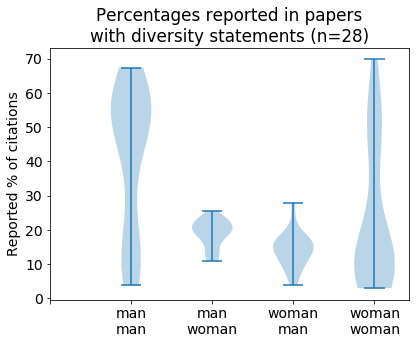

In [11]:
lists_percents = get_percentages_list(df)
data_for_visualization = list(lists_percents.values())

matplotlib.rc('font', **{'size': 14})

fig, axes = plt.subplots(figsize=(6,5))
axes.violinplot(dataset=data_for_visualization)
axes.set_ylabel('Reported % of citations')
axes.set_xticks(range(len(lists_percents) + 1))
ticks = ['', 'man\nman', 'man\nwoman', 'woman\nman', 'woman\nwoman']
axes.set_xticklabels(ticks)
plt.title('Percentages reported in papers\n' +\
          f'with diversity statements (n=%d)' %df['diversity_statement'].sum())
plt.tight_layout()
plt.savefig('../../reports/figures/violinplot_percentages.png')

## Calculate and visualize the percentages relative to the benchmarks

In [12]:
def get_percentage_differences_lists(df):

    expected_percentages = {'mm': 58.4,
                            'wm': 25.5,
                            'mw': 9.4,
                            'ww': 6.7,
    }

    lists_percent_diffs = {'mm': [],
                           'wm': [],
                           'mw': [],
                           'ww': [],
    }

    for d in df['percentages']:
        if len(d) > 0:
            for key in lists_percent_diffs.keys():
                diff = d[key] - expected_percentages[key]
                lists_percent_diffs[key].append(diff)
    return lists_percent_diffs


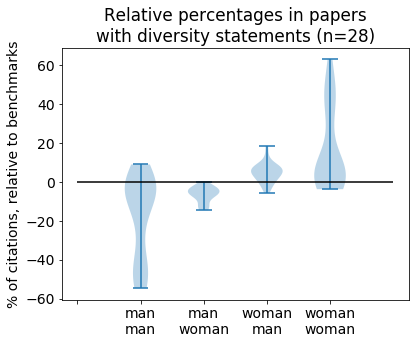

In [13]:
lists_percent_diffs = get_percentage_differences_lists(df)
data_for_visualization = list(lists_percent_diffs.values())

matplotlib.rc('font', **{'size': 14})

fig, axes = plt.subplots(figsize=(6,5))
axes.violinplot(dataset=data_for_visualization)
axes.set_ylabel('% of citations, relative to benchmarks')
axes.set_xticks(range(len(lists_percents) + 1))
ticks = ['', 'man\nman', 'man\nwoman', 'woman\nman', 'woman\nwoman']
axes.set_xticklabels(ticks)
plt.title('Relative percentages in papers\n' +\
          f'with diversity statements (n=%d)' %df['diversity_statement'].sum())
plt.hlines(y=0, xmin=0, xmax=5)

plt.tight_layout()
plt.savefig('../../reports/figures/violinplot_percentage_diffs_from_benchmarks.png')

## Relative percentages, without self-citations
i.e., excluding papers authored by Danielle Bassett 

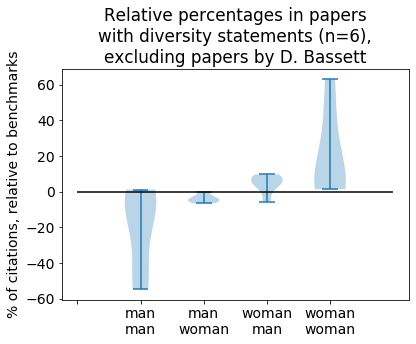

In [14]:
# select papers not authored by Danielle Bassett
# (wosc stands for 'without self-citations')
df_wosc = df[df['bassett_author'] == 0]

lists_percent_diffs_wosc = get_percentage_differences_lists(df_wosc)
data_for_visualization_wosc = list(lists_percent_diffs_wosc.values())

matplotlib.rc('font', **{'size': 14})

fig, axes = plt.subplots(figsize=(6,5))
axes.violinplot(dataset=data_for_visualization_wosc)
axes.set_ylabel('% of citations, relative to benchmarks')
axes.set_xticks(range(len(lists_percent_diffs_wosc) + 1))
ticks = ['', 'man\nman', 'man\nwoman', 'woman\nman', 'woman\nwoman']
axes.set_xticklabels(ticks)
plt.title('Relative percentages in papers\n' +\
          'with diversity statements (n=%d),\n'%df_wosc['diversity_statement'].sum()  +\
          'excluding papers by D. Bassett')
plt.hlines(y=0, xmin=0, xmax=5)

plt.tight_layout()
plt.savefig('../../reports/figures/violinplot_percentage_diffs_from_benchmarks_wo_self-citations.png')

## Relative percentages, with only self-citations

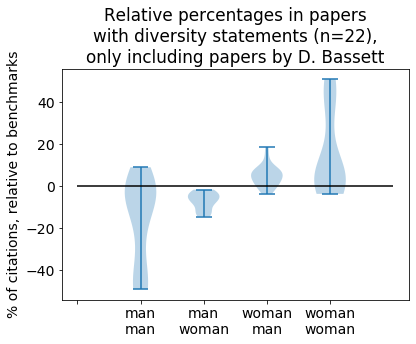

In [15]:
# select papers authored by Danielle Bassett
# (sc stands for 'self-citations')
df_sc = df[df['bassett_author'] == 1]

lists_percent_diffs_sc = get_percentage_differences_lists(df_sc)
data_for_visualization_sc = list(lists_percent_diffs_sc.values())

matplotlib.rc('font', **{'size': 14})

fig, axes = plt.subplots(figsize=(6,5))
axes.violinplot(dataset=data_for_visualization_sc)
axes.set_ylabel('% of citations, relative to benchmarks')
axes.set_xticks(range(len(lists_percent_diffs_sc) + 1))
ticks = ['', 'man\nman', 'man\nwoman', 'woman\nman', 'woman\nwoman']
axes.set_xticklabels(ticks)
plt.title('Relative percentages in papers\n' +\
          'with diversity statements (n=%d),\n'%df_sc['diversity_statement'].sum()  +\
          'only including papers by D. Bassett')
plt.hlines(y=0, xmin=0, xmax=5)

plt.tight_layout()
plt.savefig('../../reports/figures/violinplot_percentage_diffs_from_benchmarks_only_self-citations.png')